In [1]:
from importlib import reload
import config
reload(config)
import os

import torch
from torch import nn
from torchinfo import summary
from torch.utils.data import DataLoader

# %load_ext tensorboard

import dataset, loss, model, trainer
import numpy as np
import util

D:\Github\smlm-dl\smlm_dl\dataset.py:364: RuntimeWarning: invalid value encountered in log
  im = axes[1].imshow(np.log(tiled_images))


45:	 [id = 45.000,], [A = 1949.685,], [bg = 0.000,], [x = -10.342,], [y = -0.950,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
64:	 [id = 64.000,], [A = 1406.210,], [bg = 0.000,], [x = -5.930,], [y = 10.970,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
80:	 [id = 80.000,], [A = 1060.873,], [bg = 0.000,], [x = -6.162,], [y = -9.463,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
113:	 [id = 113.000,], [A = 1974.942,], [bg = 0.000,], [x = -2.370,], [y = -3.966,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
104:	 [id = 104.000,], [A = 951.144,], [bg = 0.000,], [x = -3.978,], [y = 7.184,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
33:	 [id = 33.000,], [A = 559.117,], [bg = 0.000,], [x = 6.997,], [y = 9.986,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
19:	 [id = 19.000,], [A = 1692.115,], [bg = 0.000,], [x = 9.848,], [y = 8.128,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
21:	 [id = 21.000,], [A = 566.303,], [bg = 0.000,], [x = 0.428,], [y = 

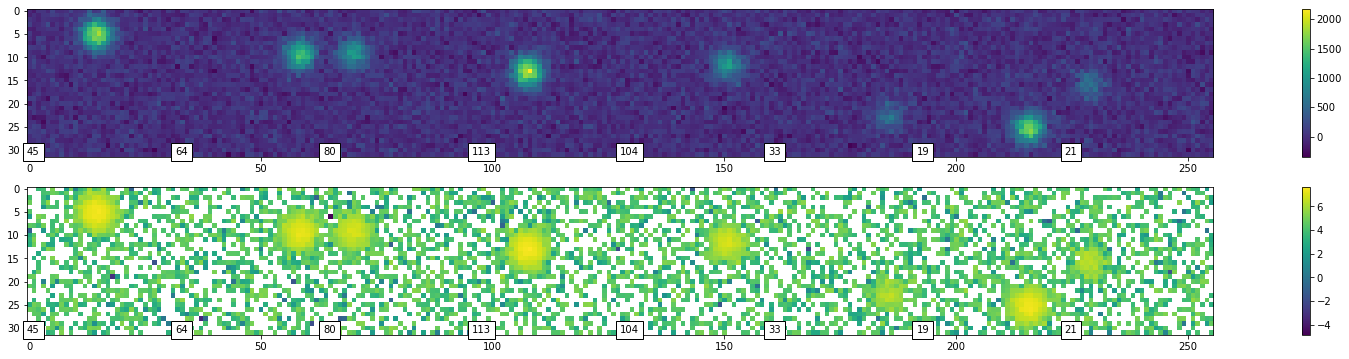

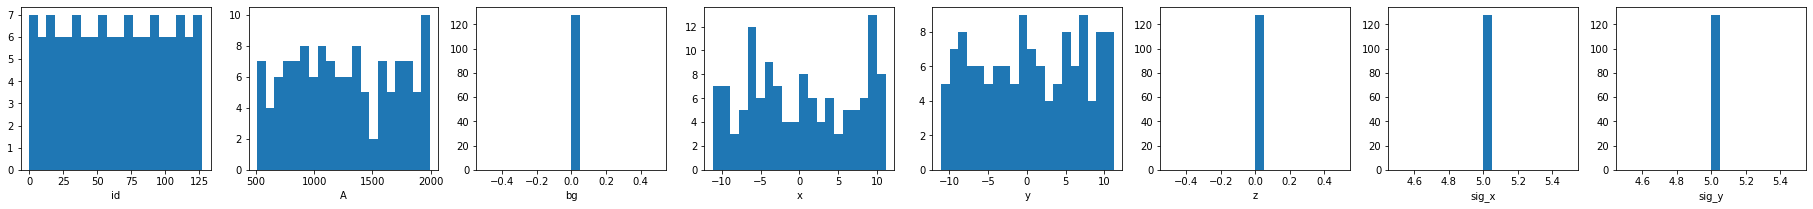

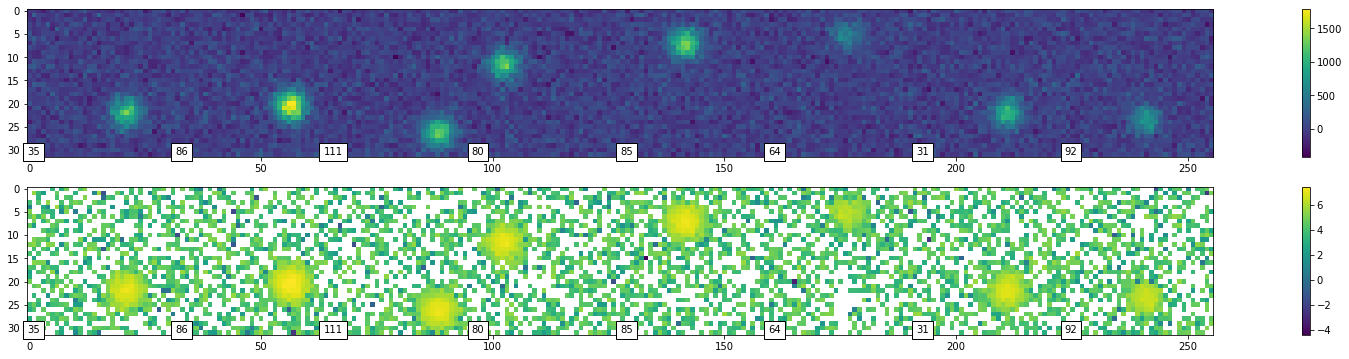

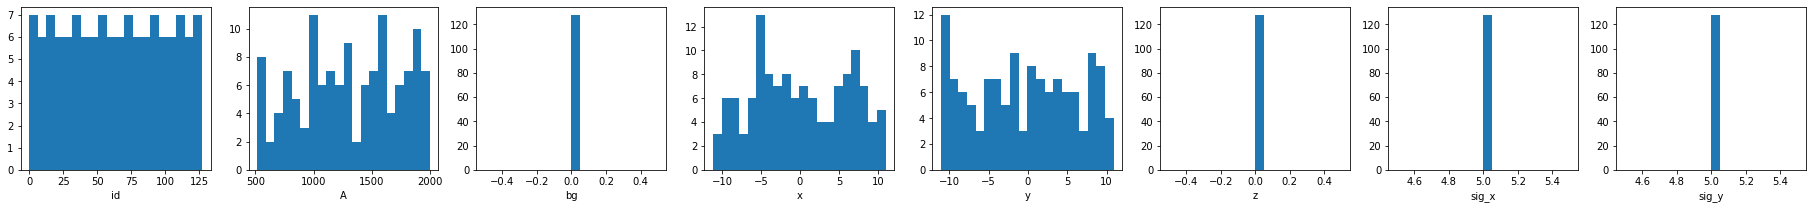

In [2]:
reload(dataset)

settings = {
    # 'out_size': (64,64),
    'length': (128, 1),
    'dropout_p': 0,
    # 'psf_params': {'z':[-10,10]},
    'psf_params': {'bg':[0,0]},
    # 'psf_zerns': psf_zerns,
    'noise_params': {'poisson': True, 'gaussian': 100},
    # 'normalize': False,
    # 'padding': (4,4),
    # 'random_z': True,
    "augmentations":{},
    # "augmentations":{"pixel shift":(4,4), }#"add noise":0.1},
    
}

training_data = dataset.Gaussian2DPSFDataset(**settings)
dataset.inspect_images(training_data)
train_dataloader = DataLoader(training_data, batch_size=128, shuffle=True)

valid_data = dataset.Gaussian2DPSFDataset(**settings)
dataset.inspect_images(valid_data)
valid_dataloader = DataLoader(valid_data, batch_size=128, shuffle=True)

['x', 'y', 'A', 'sig']
Layer (type (var_name))                       Output Shape              Param #
Gaussian2DModel                               --                        --
├─ConvImageEncoderModel (encoder)             [128, 4, 1, 1]            --
│    └─ModuleDict (encoders)                  --                        --
│    │    └─Sequential (conv_layer0)          [128, 16, 16, 16]         --
│    │    │    └─Conv2d (0)                   [128, 16, 32, 32]         160
│    │    │    └─GELU (1)                     [128, 16, 32, 32]         --
│    │    │    └─Conv2d (2)                   [128, 16, 32, 32]         2,320
│    │    │    └─GELU (3)                     [128, 16, 32, 32]         --
│    │    │    └─MaxPool2d (4)                [128, 16, 16, 16]         --
│    │    │    └─Dropout2d (5)                [128, 16, 16, 16]         --
│    │    └─Sequential (conv_layer1)          [128, 32, 8, 8]           --
│    │    │    └─Conv2d (0)                   [128, 32, 16, 16]     

C:\Users\Kenny\anaconda3\envs\smlm-dl\lib\site-packages\torch\cuda\__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


input shape: (128, 1, 32, 32), output_shape: (128, 1, 32, 32)


D:\Github\smlm-dl\smlm_dl\model\base.py:145: RuntimeWarning: divide by zero encountered in log10
  im = axes[0, i].imshow(np.log10(img))


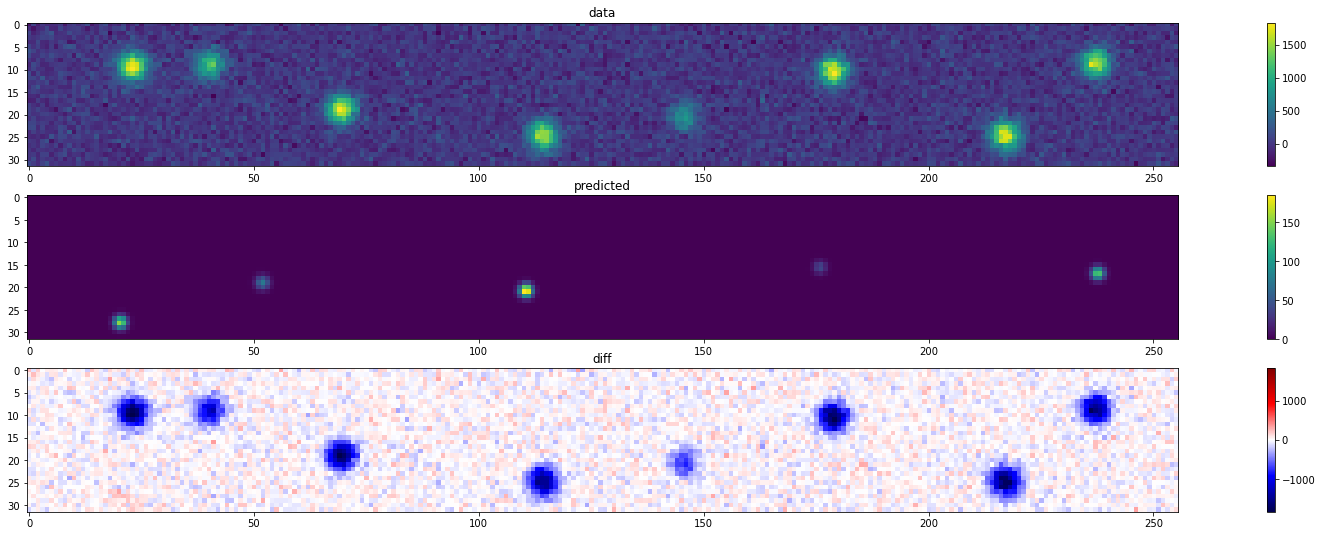

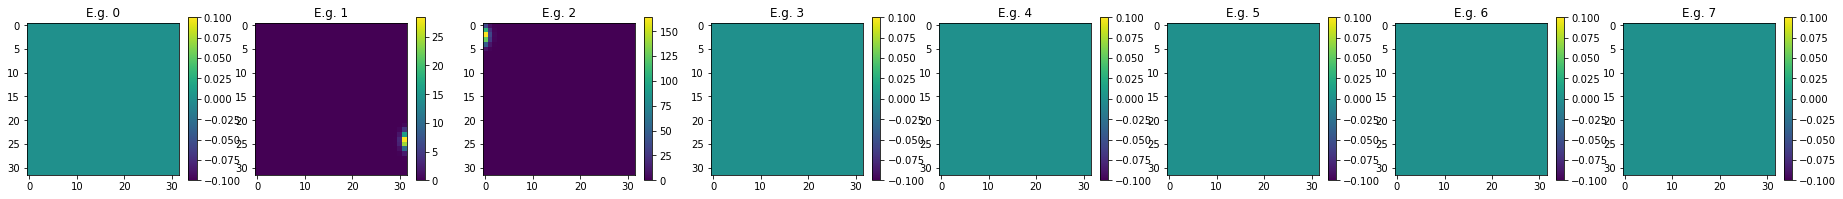

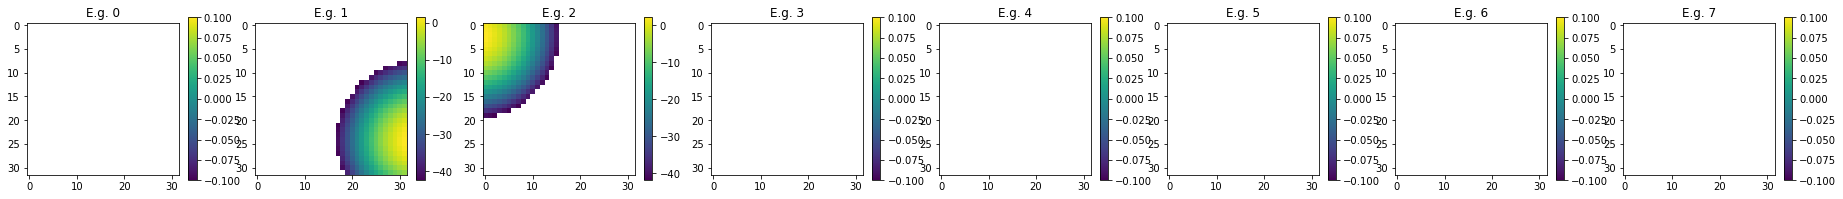

In [3]:
reload(model)

fitting_model = model.Gaussian2DModel(
                                      # img_size=(32,32),
                                      fit_params=['x','y','A','sig',],
                                      max_psf_count=1,
                                      encoder_params={
                                          # "depth":3,
                                                      # "skip_channels":4,
                                                      # "first_layer_out_channels":16,
                                                     }
                                     )

print(fitting_model.fit_params)


print(summary(fitting_model, input_size=(128,1,32,32), row_settings=["var_names"], depth=4))

model.check_model(fitting_model, train_dataloader)

In [4]:
reload(loss)

<module 'loss' from 'D:\\Github\\smlm-dl\\smlm_dl\\loss.py'>

In [5]:
# loss_func = loss.GaussMLECameraLoss((32,32), gain=1, offset=0, var=100)
loss_func = loss.GaussPoissonMLECameraLoss(gain=1, offset=0, var=100)


training = trainer.FittingTrainer(fitting_model, train_dataloader, valid_dataloader, loss_function=loss_func)
training.train_and_validate(10000, 10, 100)

CUDA not available. Defaulting to CPU
Device: cpu
Saved to : D:\Pytorch\runs\2022-03-16_20-51-33_DESKTOP-7NNT713\model.ptm


  0%|          | 0/10000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Saved to : D:\Pytorch\runs\2022-03-16_20-51-33_DESKTOP-7NNT713\checkpoint.ptc
model_state_dict: odict_keys(['encoder.encoders.conv_layer0.0.weight', 'encoder.encoders.conv_layer0.0.bias', 'encoder.encoders.conv_layer0.2.weight', 'encoder.encoders.conv_layer0.2.bias', 'encoder.encoders.conv_layer1.0.weight', 'encoder.encoders.conv_layer1.0.bias', 'encoder.encoders.conv_layer1.2.weight', 'encoder.encoders.conv_layer1.2.bias', 'encoder.encoders.conv_layer2.0.weight', 'encoder.encoders.conv_layer2.0.bias', 'encoder.encoders.conv_layer2.2.weight', 'encoder.encoders.conv_layer2.2.bias', 'encoder.neck.conv_layer_0.0.weight', 'encoder.neck.conv_layer_0.0.bias', 'encoder.neck.conv_layer_0.1.weight', 'encoder.neck.conv_layer_0.1.bias', 'encoder.neck.conv_layer_0.3.weight', 'encoder.neck.conv_layer_0.3.bias', 'encoder.neck.conv_layer_0.4.weight', 'encoder.neck.conv_layer_0.4.bias', 'encoder.neck.conv_layer_1.0.weight', 'encoder.neck.conv_layer_1.0.bias', 'encoder.neck.conv_layer_1.1.weight', 'enc

KeyboardInterrupt: 